# Kaggle IEEE-CIS Fraud Detection

本文主要介绍了一些自己在 Kaggle 上首战的经验，包括数据分析，特征工程，模型选择与训练等内容。  

首先拿到一个比赛题目，先明确题意，即要解决的问题，这里分为两部分：  
1. 这个比赛需要我们解决什么现实问题？  
> 这明确了我们可能需要用到的相关领域知识，以及对后续的特征构建或有启发意义；
2. 这是什么类型的机器学习任务？有监督/无监督，分类/回归，是否需要处理图片和文本等等。  
> 这决定我们需要用哪些方式做数据清理、分析，以及用什么模型学习特征。   

其次，对数据集进行初步探索和分析(EDA)，这一过程包括清洗数据和可视化分析，为后续提取和构建特征做铺垫；     

之后，是最重要的特征工程(FE)，在这一过程中，需要不断尝试、测试新特征，除了基本的特征提取方法外，经常关注讨论区也能给予自己寻找特征的灵感，这一步是为了训练模型做特征上的准备，特征的好坏能很大程度上影响模型学习的效果；  

最后是选择并构建模型，学习特征并预测结果，本题选择了在其他 kernel 中广受好评的 LightGBM，用 5 折交叉验证防止过拟合并评估模型性能。   

另外，本次比赛中，我还有许多不足之处，写在文末的总结中。

# 问题描述
- 任务概述：通过给定的在线电子交易信息，预测该交易是否为欺诈交易；
- 任务类型：有监督，二分类；
- 数据集：
    train/test_identity -用户身份信息；
    train/test_transaction -交易信息；
- 评测方式：[ROC 曲线下面积(AUC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) ;
- 提交格式：    
TransactionID,isFraud  
3663549,0.5  
3663550,0.5  
3663551,0.5  
etc.   

现在已经明确了题意 -- 有监督，二分类，需要预测欺诈性交易；  

# Part1. 探索性数据分析 (EDA) 

- 这部分主要是对数据集有一个基本的了解,对之后的特征工程起一个启发式作用。  

- 比如，从整体上来说可以考虑：一共多少列特征，多少数值型特征、多少类别型特征，是否出现类别分布不均衡问题？    

- 具体到每一个特征就是，考察特征分别在正样本和负样本中如何分布，有什么异同？各个特征的缺失值都有多少？ 重点关注负样本的特征数据，看看能不能发现什么具有代表性的特征等等。 
> 对类别型特征可以计数统计，这里绘制直方图会更加直观，连续数值特征可以绘制核密度图来看其概率分布。  
缺失值统计可以直接调用 ```df.isnull().sum()```

In [3]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


能看到现在有 434 列特征，面对如此高维的特征，能想到我们在特征提取上会有很多工作要做。下面结合讨论区对各个特征的解释，来观察各列。

## 原始特征
- 交易信息特征：
    - ```TransactionDT```：给定参考日期时间的时间戳（不是实际时间戳）
    - ```TransactionAMT```：以美元为单位的交易支付金额
    - **```ProductCD```**：产品或服务类型
    - **```card1-card6```**：支付卡信息，例如卡类型，卡类别，发行银行，国家等
    - **```addr1/2```**：交易地址
    - ```dist```：距离
    - **```P_/R__```** :电子邮件域名：买方和收件人电子邮件域名
    - ```C1-C14```：计数，例如发现与支付卡关联的地址数等。实际含义被屏蔽
    - ```D1-D15```：时间间隔，例如与前一次交易之间的天数等
    - **```M1-M9```**：个人信息是否匹配，例如卡上的姓名和地址是否匹配等
    - ```Vxxx```：其他的特征
- 身份信息特征：
    - **```DeviceType```**：交易设备
    - **```DeviceInfo```**：交易设备
    - ```id_01 - id_11```：身份的数字特征
    - **```id_12 - id_38```**：身份的类别特征 
    
> 加粗黑体为类别型特征     

官方给出的标记规则：    

Labeling logic   

"The logic of our labeling is define reported chargeback on the card as fraud transaction (isFraud=1) and transactions posterior to it with either **user account**, *email address or billing address directly linked to these attributes as fraud too*. If none of above is reported and found beyond 120 days, then we define as legit transaction (isFraud=0)"

可以发现，一共 434 列特征 V 系列特征就足足占了 341 列！猜想这个系列的特征大概会存在很多冗余列，我们在特征提取的时候可以进行必要的降维；   
  
  
另外，我们还可以注意到 C系列、D 系列、M 系列 和 id 系列特征的具体含义都不清晰，如果能够通过特征工程进一步猜想出系列特征的具体含义，或许对构建特征有启发意义。  

关于标记规则，自己在参加比赛的时候并没有特别注意这里，只是按照常见的方法做特征工程，直到比后来看到比赛排名十分靠前的选手公布他们的方案时，才发现这里其实可以说大有玄机。是启发 "构建特征 + 选择特征" 的关键， 具体写在文末总结中。

## 接下来思考的问题
1. 类别型特征如何处理，数值型数据如何处理？  
    - 针对类别型特征，有几种编码方式可以将其转换成数值类型，方便模型学习。具体采用哪种编码方式，需要具体分析，见后文；   

    - 对于数值型特征，在后续的特征工程中做了总结，在特征工程之前，可以先通过转换数值类型的方式减少数据占用的内存，提高之后模型的训练速度；  
    eg. 将所有 float64 转换为 float32 ，将所有 int64 转换为 int32。（最好避免使用 float16。如果愿意，可以使用 int8 和 int16 ）
>trick: 自己没有思路的时候，可以多看别人的 kernel 并关注讨论区，我发现大家对新手都很友好，即使问大神很基础的问题，他们也都会耐心解答，是真的很 nice :D
2. 正负样本分布是否均衡，是否需要重采样？   

In [22]:
train["isFraud"].value_counts(normalize="TabErrorrue")

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

Text(0.5, 1.0, 'Target variable count')

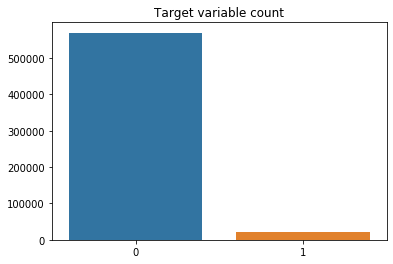

In [25]:
# 正负样本分布
import seaborn as sns
import matplotlib.pyplot as plt
x=train['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

- 当正负样本分布不均衡(通常把样本类别比超过 4:1 的数据称为不均衡数据)时，分类模型会存在严重的**偏向性**，举一个极端的例子，如果以准确率作为验证指标，当模型预测所有的样本都是负样本时，准确率可以达到 0.96501 ！这个时候显然是发现不了自己模型问题的，但如果测试集中给出一个正负样本分布较为均衡的数据集，所得结果可想而知。  
- 解决方法：
    - **调整衡量模型的指标**。即，不能再用「分类正确率」（accuracy）来衡量模型性能，而要用少数类的「准确率」（precision）和「召回率」（recall），或者二者的综合（F1, equal error rate, area under curve 等等）。本题中使用的 AUC 值其实并不能很好的规避样本不均衡的弊端；  
    - **交叉验证**√，提高模型鲁棒性；  
    - **数据集重采样** -- 对样本占比小的类别过抽样，样本占比大的类别欠抽样，这里可以参考一个 [kernel](https://www.kaggle.com/shahules/tackling-class-imbalance) ; 
    > 此种方法缺点也比较明显，比如欠抽样时会浪费一些数据，而过抽样又容易造成过拟合问题等。
    - **使用现有的集成学习分类器**√，比如 LightGBM ，不论是二分类还是多分类，只要恰当设置参数就能解决这个问题。  
    > 比如针对本题的二分类，设置```is_unbalance```参数为```True```或者设置```scale_pos_weight```,二者只能选一个。 设置```is_unbalance```参数为```True```时会把负样本的权重设为：正样本数/负样本数。

3. 是否需要可视化？  
    - 可视化对数据的分析和探索绝对会取得很棒的辅助作用，但对于新手来说，不用太执着于自己做可视化。  因为 python 的可视化工具多且全，一时间完全掌握并熟练运用对新手来说实在是不太友好。  
    - 比赛初期就会有人共享出他的数据可视化方案了，如果是新手的话，初期不必浪费时间学习可视化内容，可以从别人的 kernel 中寻找灵感。

比赛中分享出来的优秀 EDA：
- [🕵️ IEEE Fraud Detection - First Look and EDA ](https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda)
- [EDA and models](https://www.kaggle.com/artgor/eda-and-models/data)  
- [fraud-complete-eda](https://www.kaggle.com/jesucristo/fraud-complete-eda)

# Part2. 特征工程（FE）
这部分包括对原始特征的预处理和在已有特征基础上构建新的特征，以利于模型的学习，最终目的是使预测结果比起直接使用原数据来说，更加准确。    

这是提高分数的重要步骤:加入新特征->模型本地评估(cv 交叉验证) or feature importance ->  筛选特征...   

这部分除了会应用到一些基本的数据处理方法外，还不可避免的需要依靠分析数据的经验和创造力。
> 在 kaggle 的讨论区中，有时 kaggler 会表示自己发现了 "magic feature" ，该种特征会对最后的预测结果起关键性作用。因此如果能找到 "magic feature" ，那当然是很幸运的。通常情况下，我们会选择按常规步骤和专业领域知识不断补充和筛选特征，在这个过程中也许会发现 "magic  feature"。   

## 缺失值处理
1. 统计缺失值，每一笔交易的所有缺失值数量可以当做特征。
2. 直接丢弃缺失值大于 90% 的特征；
3. 插补法填充缺失值：
    - 平均值、中位数插补，特殊值(eg.-999)插补；   
    - K 临近距离法： 先根据欧式距离或相关分析来确定距离具有缺失数据样本最近的K个样本，将这 K 个值加权平均来估计该样本的缺失数据；
    - 期望最大化算法(EM 算法)


## 异常值处理  
1. 画图表，单一特征绘制箱型图(box plot)；两两特征绘制散点图(scatter plot);
2. 根据公式计算异常点，套用处理缺失值的方法 √
```python
    # calculating mean and std(标准差) of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3 

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut
```

## 特征缩放  (Feature Scaling)
- 特征缩放，是预处理阶段的关键步骤，能使不同的特征有相同的取值范围。虽然存在决策树和随机森林这种少数不需要特征缩放的机器学习类算法，但对于大部分机器学习算法和优化算法来说，如果特征都在同一数值范围内，会得到更好的结果；  

**Q1: 原因及必要性?**
1. 归一化/标准化实质是一种线性变换，线性变换有很多良好的性质，这些性质决定了对数据改变后不会造成“失效”，反而能提高数据的表现，这些性质是归一化/标准化的前提。
2. 梯度下降方法求解最优化问题的需要：能够使等高线变圆，加快其收敛速度；
3. 一些分类器的目标函数(损失函数)需要计算样本间的距离、方差等，如果一个特征域范围过大，则计算结果主要取决于这个特征，这与实际情况往往是相悖的;     


**Q2：什么时候需要特征缩放？** 
1. 涉及或隐含[距离计算的方法](https://blog.csdn.net/Kevin_cc98/article/details/73742037)，包括欧式距离、马氏距离、余弦距离等。
2. 损失函数中包含正则项；
3. 梯度下降算法；    
> eg. SVM, logistic regression   

**Q3: 什么时候不需要？**  
1. 与距离计算无关的概率模型；
> eg. Naive Bayes  
2. 基于树的模型，树中结点的选择值关注当前特征在哪里切分能使分类结果更加准确，这种划分方法只关注特征内部数据，而不关注特征之间的相对大小。
> eg. 决策树，随机森林等。
    
### 标准化  (Normalize)  
  Z-score 标准化：将特征值缩放到以 0 为中心，标准差为 1，即，标准化后的特征形式服从正态分布。  
  另外，标准化后的数据保持了异常值中的有用信息，使得算法对异常值不太敏感，这一点归一化无法保证。 
```python
df[col] = (df[col]-df[col].mean())/df[col].std()
```
### 归一化  (Standardize)  
将特征范围缩放到 $[0,1]$  


In [ ]:
# sklearn 提供了 MinMaxScaler 类实现归一化
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train) # 注意只用训练集数据 fit 一遍，以保证训练集和测试集的缩放程度相同
X_test_norm = mms.transform(X_test)

## 特征变换    
对类别型特征，可以选择告诉 LightGBM 他们是类别型特征。如果预先对类别特征有数值编码操作(比如 card1)，也可以告诉 LightGBM 他们是数值型特征。虽然即使不这么做， LightGBM 也能自动抽取类别型特征，但我们可以两者都尝试并看 CV 的验证分数，取其高者为用。  
```train[col] = train[col].astype("category")```
###  Log Transformation    

针对数值型，特别是极差特别大的数值型特征，可以对其取 log。因为 x 越大，log(x) 就增长的越缓慢，取对数之后可以让数据的分布更加平稳，同时也能使计算变得简单。 
```python
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])  
```
类似的数学变换还有根式运算等；  

###  Label Encoding    
对离散的数字或文本特征编码，当特征的各个类别之间存在一定的逻辑时，选用 Label Encoding 会更加合适，因为编码的数字顺序可以与原有逻辑对应，而不破坏它。

###  One-hot Encoding   
独热编码：又称一位有效编码，用 N 维向量来对 N 个状态编码，在任意情况下，该 N 维向量只有一位有效。
- 优点：
    - 解决了一些分类器不好处理类别型数据的问题；
    - 在一定程度上也起到了扩征的作用；
- 缺点：
    - 类别过多时容易产生维数灾难；
    - 对于基于树的模型来说，本质是在增加树的深度，所以并不适合基于树的模型。

In [ ]:
# 对类别型特征数值化编码
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))


## 特征构建 (Feature Construction)    
指从原始的特征中，人工创造出新的特征。   
这部分个人认为主要靠数据分析的经验 + 题目涉及领域的专业知识 + 与其他参赛者的交流；

### 时间特征    
本题中，数据集中给出的 ```TransactionDT``` 并不是具体的时间，而是与某个具体时间的间隔(单位可以猜测为 "秒")。所以，对```TransactionDT```，可以进一步构建出```Transaction_day_of_week```,```Transaction_hour```.    
```python
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24
```
###  Splitting  
字符串列可以按照字符串的特点分裂成两个及以上列，比如邮件域名、交易金额、使用设备等。这些分裂出来的新特征信息，只靠原始数据和 LightGBM 是得不到的。  

- 邮件域名  

    交易信息中，买方和卖方的邮件域名都十分重要，因为有可能欺诈交易的邮件域名有某些相似之处。   
    他们有长 ```nan```这样的，也有```hotmail.com```这样的，还有```prodigy.net.mx```这样的，于是对他们的处理就是按 ``` . ```分开，分别构建三列特征：

```python  
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)  
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
```  


- TransactionAmt  
    交易金额可以划分成整数部分和小数部分。  
```python  
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
```  
- DeviceInfo   

    ```id_30``` 中 ```Mac OS X 10_9_5``` ，```Mac OS X``` 是操作系统类型，```10_9_5```是该操作系统的版本。由此即可分成两列特征。

### Frequency Encoding
对一些类别型特征(包括缺失值)来说，可以统计各类别出现的次数，作为新的特征。
```python
# map 理解成映射
train['card1_count_full'] = train['card1'].map(
    pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))  

# 统计缺失值
train_df['nulls1'] = train_df.isna().sum(axis=1)
```  


### Combining / Interaction      

这两种方法看似简单，实际上却可以挖掘出几个 feature 之间内在的联系，比如单个的特征并不能看出与 target 有多少关联，模型在学习的时候也就不会重视这些特征，但十分有可能的是，两个特征联合起来就与 target 的判断其很大作用。  

- Combining    
主要针对 categorical 特征，把两个或以上的特征通过某种方式结合在一起.。  
比如直接联合：  

```python 
# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2',
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:
    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

```    

- Interaction    
主要针对数值型特征。可以用 A + B , A - B, A * B ,A/B 等基本数学运算建立新特征；   

```python
train["x1_x2"] = train["x1"] * train["x2"]
```

### 特征聚合    (Aggregations/ Group Statistics)
这里引用一段大神 ([Chris Deotte](https://www.kaggle.com/cdeotte)) 在讨论区对这个工作用处的解释：  
"  
  Creating group aggregation features are great for detecting anomalies.   
  
  Every transaction belongs to many groups. Whenever a transaction differs from the normal within that group, it is suspicious of being fraud.  
    
  For example, you can encode df.groupby('addr1').TransactionAmt.agg('mean'). This is the average amount of money spent within each addr1 (i.e. zipcode). If everyone in a certain zipcode only purchases items less than ```$100``` and then one client from that zipcode purchases something for ```$1000``` that is strange and possibly fraud.   
  "  
  
  也就是说，特征分组聚合可以帮助我们的模型发现在该组中，有哪些值是 common 的，那些值是 rare 的，自然，拥有与众不同的值的样本是欺诈交易的可能性很大（因为之前已经发现所有的交易中，欺诈交易只占很少的一部分），以此来提升模型预测的准确性。

```python
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')
train['TransactionDT_to_std_TransactionID']=train.groupby(['TransactionDT'])['TransactionID'].transform('std')
```  

## 特征提取  
特征提取是从原始特征空间抽取信息，从而构建一个新的特征子空间。
- 降维
    - PCA (Principal Component Analysis) :是一种常见的数据分析方式，常用于高维数据的降维，可用于提取数据的主要特征分量；  

In [ ]:
# 对 v 系列特征 PCA 降维
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

    
## 特征选择  
特征选择从原始体征集中选择一个子集合。  
> 删除不必要的列:
    - 该特征中全部都只有一个值；
    - 该特征中 90% 以上是 nan ；
    - 该特征中有一个值出现 90% 以上；  
    
### Filter Method  
过滤法：采用某一种评估方法(相关性，假设检验等），单独衡量每一个自变量与因变量之间的关系，给出每一个自变量对因变量的影响程度。整个过程没有用到模型。  

### Wrapper Method   
包装法：将特征选择算法作为学习算法的一个组成部分，并且直接使用分类性能作为特征重要性程度的评价标准。  
以递归式特征消除为例，递归式特征消除的目标是通过递归的考虑越来越小的特征集来选择特征，知道符合特征数量满足要求为止。缺点是时间复杂度较高。
> [交叉验证递归式特征消除](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) √
```python
from sklearn.feature_selection import RFECV
```     
### Embedded Method   √
嵌入法，也是用机器学习的方法来选择特征，但和 wrapper 的方法的区别在于，不是通过一些迭代方法选择特征子集，而是直接使用原特征全集训练之后，得到特征系数 coef 或者特征重要度 feature importance ，取前 k 个特征作为特征子集。


 ## 特征学习
- GBDT
- 过拟合问题的解决方法：
    - 特征选择与特征提取；√ 
        - 包括重新清洗数据：异常点，消除冗余特征等；
    - 交叉验证；√ 
    - [正则化](https://ljalphabeta.gitbooks.io/python-/content/selecting.html)："优化目标 + 正则项(惩罚项)" -- 惩罚大权重参数，降低模型复杂度 ；
    > - 奥卡姆剃刀原理说，在所有能解释数据的模型中，越简单的越靠谱。但是为了拟合复杂的数据，不得不采用更复杂的模型，而正则化方法就是，以一种相对比较简单的模型来拟合复杂数据的方法。   

# Part 3. 模型的选取与构建

## 模型选择    

适用于高维度特征的二分类问题  
个人只使用单模型训练，但大多数参赛选手都会使用模型融合的方法得到更优解，这一点也写在最后的总结中。  

 - [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)     
 
  
  
## 模型评估和调参    

### K折交叉验证评估模型的性能      

- K 折交叉验证过程：
    - 1. 使用不重复随机抽样将原始数据随机分为 k 份；
    - 2. k - 1 份用于模型训练，剩下的 1 份用于模型测试；
    - 3. 将 (2) 重复 k 次;  
    最后得到 k 个模型和他们的评估结果；
    > k 一般取值为 5、10，数据量较大时，k 应该设定的小一些，不然导致各个模型的训练集相差不多，反而容易过拟合。  
    
### 超参调整 -- 网格搜索，随机搜索与贝叶斯优化  
#### 网格搜索  
网格搜索其实就是暴力搜索，我们事先为每个参数设定一组值，然后穷举各种参数组合，找到最好的那一组。 但这种方法太过耗时，显然不适合大样本的数据集。
```python
from sklearn.model_selection import GridSearchCV
```
#### 随机搜索   
与网格搜索相比，随机搜索不会尝试所有的参数组合，而是从指定的参数范围中随机采样，如果采样的样本集足够大，则得到的参数组合很有可能是最优参数或者近似于最优参数。  
但这种方法同样不适合大样本数据集。  
```python
from sklearn.model_selection import RandomizedSearchCV
```
#### 贝叶斯优化调参  √
  
[强大而精致的机器学习调参方法：贝叶斯优化](https://www.cnblogs.com/yangruiGB2312/p/9374377.html)  
[kaggle-Tutorial: Bayesian optimization](https://www.kaggle.com/clair14/tutorial-bayesian-optimization)

- 主要思想： 给定优化目标函数(广义的函数，只需要给出函数的输入和输出即可)，通过不断增加样本点来更新目标函数的后验分布，换句话说，就是不断考虑上一次参数的信息，从而更好的调整当前的参数。  

1. 优化目标函数：参数是需要调整的参数，返回优化目标的分数；
> 这里提前把数据集划分成训练集和验证集，优化目标的分数是使用训练集数据在 lightgbm 训练过后，在验证集上验证后所得的 AUC 值；    
2. 确定参数范围；
> 参考 lightgbm 的官方文档和已经分享出来的 kernel；  
3. 调用 maxmine 方法，自动寻找最优参数组合；

In [3]:
# 贝叶斯优化调参
# pip install bayesian-optimization
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

## 模型融合 -- Voting 简单投票法

在模型选择初期，尝试了 逻辑回归、SVM、决策树、朴素贝叶斯等分类模型训练数据，并对上述模型用简单投票法做了集成。

```python
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
```

# 总结  

   在经过上述特征工程之后，分数基本可以保持在 Top 50%，达成了最初参赛的目标，也就没有再进一步修改代码。  
   
   之后看到一个 kernel 中，把其他人分享出来的 submission 和自己的预测结果加权平均后，提交了新的 submission，排名一下提升了很多。照着这个办法，我也试了一番，名次排到 Top23%，说实话惊讶不小。虽然评论区有不少人说该方法会导致过拟合，这么做肯定不会在后续的私有集评测中取得好成绩，但在后来的私有数据集评判中，我的名次反而上升到 18%，又是一个小惊喜hhh.   

   总的说来，利用别人预测好的结果总是对自己能力的提升十分有限，所以我此次比赛的实质性成绩也就是 Top50%，期待下次比赛能有更好的成绩。  

下面总结一下赛后大神们分享出来的解决方案中我没有考虑到的部分：
## 特征工程部分   

### userID  
[排名 1st 的大神发布的分析贴](https://www.kaggle.com/c/ieee-fraud-detection/discussion/111510)  
正如刚开始观察到的，这个数据集的特征有 430 列，目标是识别哪一笔交易是欺诈交易。那么有哪些列可以帮助我们区分用户呢？这就是创建 userID 的最初想法。  
这里引出我们最早提到的标记规则，

### magic feature -- D 系列特征的聚合     


### 特征选择 -- 利用时间特征 


## 模型选择与构建  
### 多模型融合  